In [1]:
import torch
from torch import nn
from torch import Tensor
from torch.nn import functional as F

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda

from tqdm import tqdm
from matplotlib import pyplot as plt

tensor(4)


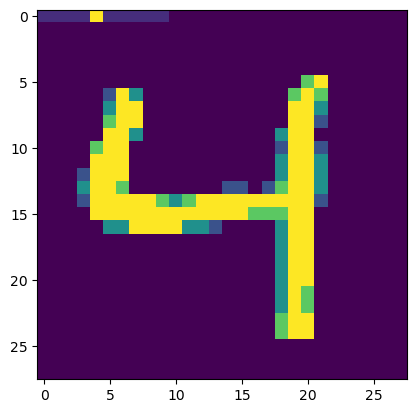

In [62]:
class MnistLoader:
    def __init__(self, train: bool, batch_size: int):
        self.batch_size = batch_size
        self.dataLoader = iter(self.__mnist_loader(train=train, batch_size=batch_size))
    
    def __mnist_loader(self, train: bool, batch_size: int) -> DataLoader:
        '''
        pytorch MNIST train & test 데이터 로더 반환
        + z-normalization
        + Flatten
        '''
        transform = Compose([
            ToTensor(),
            Normalize(mean=(0.1307, ), std=(0.3081, )),
            Lambda(lambda x: torch.flatten(x)),
        ])

        loader = DataLoader(
            MNIST(
                root='./mnist/',
                train=train,
                transform=transform,
                download=True
            ), shuffle=train, batch_size=batch_size
        )
        return loader
    
    def __create_input_data(self, x: Tensor, y: Tensor) -> Tensor:
        '''
        forward-forward Model 입력 데이터 반환

        X shape: Batch x 784(Ch * Height * Width)
        Y shape: Batch x Label
        '''
        batch_size = y.size(0)

        x_ = x.clone()
        x_[:, :10] = 0.
        x_[range(batch_size), y] = x_.max()
        return x_
    
    def __iter__(self):
        return self
    
    def __next__(self) -> ((Tensor, Tensor), (Tensor, Tensor)):
        pos_x, pos_y = next(self.dataLoader)
        neg_x, _ = next(self.dataLoader)
        neg_y = torch.randint(low=0, high=10, size=(self.batch_size, ))
        
        pos_x = self.__create_input_data(pos_x, pos_y)
        neg_x = self.__create_input_data(neg_x, neg_y)
        return (pos_x, pos_y), (neg_x, neg_y)

In [4]:
class FFLinear(nn.Linear):
    __constants__ = ('in_features', 'out_features')
    in_features: int
    out_features: int
    weight: Tensor
        
    def __init__(self, in_feature: int, out_features: int, bias: bool=True, device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FFLinear, self).__init__(in_feature, out_features, bias, **factory_kwargs)
        
        self.activation = nn.ReLU()
        self.optim = torch.optim.SGD(self.parameters(), lr=0.01)
        self.threshold = 2.0
        
    def forward(self, input) -> Tensor:
        out = self.__layerNorm(input)
        out = F.linear(out, self.weight, self.bias)
        return self.activation(out)
    
    def update(self, pos_x, neg_x) -> (Tensor, (Tensor, Tensor)):
        pos_out = self.forward(pos_x).pow(exponent=2).mean(dim=1) #shape: (Batch, )
        neg_out = self.forward(neg_x).pow(exponent=2).mean(dim=1) #shape: (Batch, )
        
        loss = torch.cat([-pos_out + self.threshold, neg_out - self.threshold])
        loss = torch.log(1. + torch.exp(loss)).mean()
        
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
        return loss, (self.forward(pos_x).detach(), self.forward(neg_x).detach())
    
    def __layerNorm(self, input: Tensor, eps: float=1e-4) -> Tensor:
        '''
        + 참고 repository의 정규화 코드
        input / (input.norm(p=2, dim=1, keepdim=True) + 1e-4)
        
        ## https://github.com/mohammadpz/pytorch_forward_forward/blob/main/main.py
        '''
        mean_ = input.mean(dim=1, keepdim=True)
        var_ = input.var(dim=1, keepdim=True, unbiased=False) #unbiased True=(N-1), False=N
        return (input - mean_) / torch.sqrt(var_ + eps)

In [5]:
class FFModel(nn.Module):
    __constants__ = ('dims', )
    dims: list
        
    def __init__(self, dims: list, device='cpu') -> None:
        super(FFModel, self).__init__()
        self.layers = tuple(FFLinear(dims[d], dims[d+1]).to(device) for d in range(len(dims) - 1))

    def forward(self, input) -> Tensor:
        pass
    
    def update(self, pos_x, neg_x) -> None:
        pos_out, neg_out = pos_x, neg_x
        for layer in self.layers:
            loss, (pos_out, neg_out) = layer.update(pos_out, neg_out)

In [13]:
dataLoader = MnistLoader(train=True, batch_size=2)

for pos, neg in dataLoader:
    pos_x, pos_y = pos
    neg_x, neg_y = neg
    
    plt.imshow(pos_x[0].view(28, 28))
    print(pos_y[0])
    break
    
    
train_loader, test_loader = mnist_loader(train_batch_size=2, test_batch_size=1)
model = FFModel(dims=(784, 100, 100))

for i in range(10001):
    x, y = next(test_loader)


StopIteration: 